In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt 

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

def calcSampleEnrichment( T_Proportion, N_Proportion, epsilon=(0.1)**6 ):
    return np.log2( (T_Proportion+epsilon)/(N_Proportion+epsilon) )

In [3]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

In [4]:
dict_Identifier_to_lvl_1_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl1.pickle')

dict_Identifier_to_lvl_2_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl2.pickle')

dict_Identifier_to_lvl_1_CellType_Total,  dict_Identifier_to_lvl_2_CellType_Total = dict(), dict()

for k,v in dict_Identifier_to_lvl_1_CellType_1.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_2.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_3.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v

for k,v in dict_Identifier_to_lvl_2_CellType_1.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_2.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_3.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v

In [5]:
adata_chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [19]:
lvl1_celltype = list()
lvl2_celltype = list()

for tup in adata_chen.obs.itertuples():
    if tup.Manual_CellType_lvl_1 == 'Tumor epithelial':
        lvl1_celltype.append('Epithelial')
        lvl2_celltype.append('Tumor epithelial')
    elif tup.Manual_CellType_lvl_1 == 'Normal epithelial':
        lvl1_celltype.append('Epithelial')
        lvl2_celltype.append(dict_Identifier_to_lvl_2_CellType_Total[tup.Identifier])
    else:
        lvl1_celltype.append(dict_Identifier_to_lvl_1_CellType_Total[tup.Identifier])
        lvl2_celltype.append(dict_Identifier_to_lvl_2_CellType_Total[tup.Identifier])
        
adata_chen.obs['Manual_CellType_lvl_1'] = lvl1_celltype
adata_chen.obs['Manual_CellType_lvl_2'] = lvl2_celltype

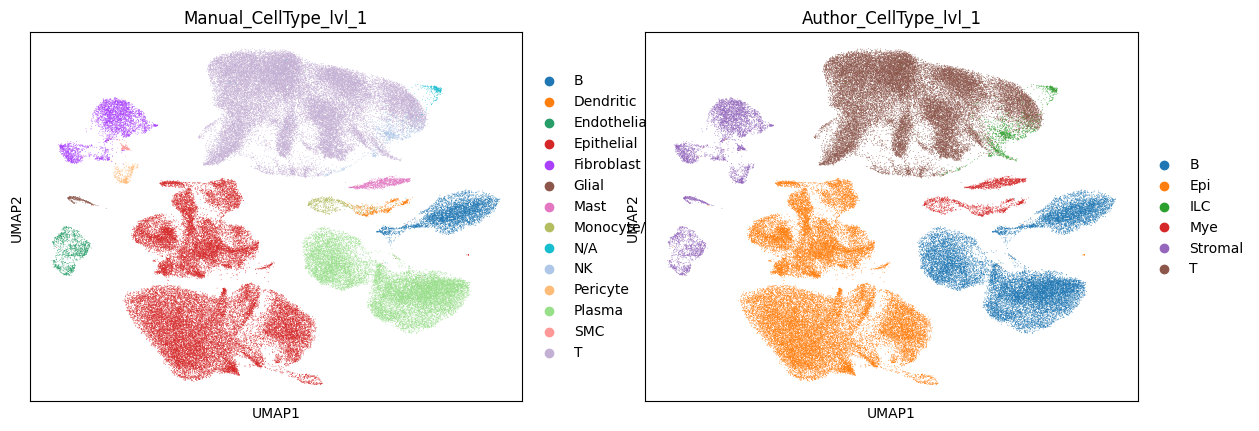

In [21]:
sc.pl.umap(adata_chen, color=['Manual_CellType_lvl_1', 'Author_CellType_lvl_1'])

In [4]:
adata_chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.AuthorAnnot.TME.h5ad')

## TME Cell Type proportion (without Epithelials)

In [5]:
adata_chen_tumorSamples  = adata_chen[adata_chen.obs['BiopsySite']=='Tumor'].copy()
adata_chen_normalSamples = adata_chen[adata_chen.obs['BiopsySite']!='Tumor'].copy()

sc.pp.normalize_total(adata_chen_tumorSamples)
sc.pp.log1p(adata_chen_tumorSamples)
sc.pp.normalize_total(adata_chen_normalSamples)
sc.pp.log1p(adata_chen_normalSamples)

### level 1

In [7]:
AuthorCellTypeLvl1_ProportionByPatient = list()

for PatientID, edf in adata_chen_tumorSamples[(adata_chen_tumorSamples.obs['Author_CellType_lvl_1']!='Epi')].obs.groupby('PatientID', observed=True,):
    for Author_CellType_lvl_1, edf2 in edf.groupby('Author_CellType_lvl_1', observed=True):
        AuthorCellTypeLvl1_ProportionByPatient.append( [PatientID, Author_CellType_lvl_1, len(edf2), len(edf2)/len(edf), edf.iloc[0].Response] )
        
AuthorCellTypeLvl1_ProportionByPatient = pd.DataFrame(AuthorCellTypeLvl1_ProportionByPatient, columns=['PatientID', 'Author_CellType_lvl_1', 'Count', 'Proportion', 'Response'])

dict_PatientID_to_AvgSTRDiff        = { PatientID : np.mean(edf['AvgSTRDiff']) for PatientID, edf in adata_chen_tumorSamples.obs[(adata_chen_tumorSamples.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].groupby('PatientID', observed=True) }
dict_PatientID_to_TumorCellCount    = { PatientID : len(edf) for PatientID, edf in adata_chen_tumorSamples.obs[(adata_chen_tumorSamples.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].groupby('PatientID', observed=True) }


AuthorCellTypeLvl1_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl1_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl1_ProportionByPatient['PerTumorCell'] = [ tup.Count/tup.TumorCellCount for tup in AuthorCellTypeLvl1_ProportionByPatient.itertuples() ]

PearsonRResult(statistic=-0.3266884691249725, pvalue=0.3568784108761661)

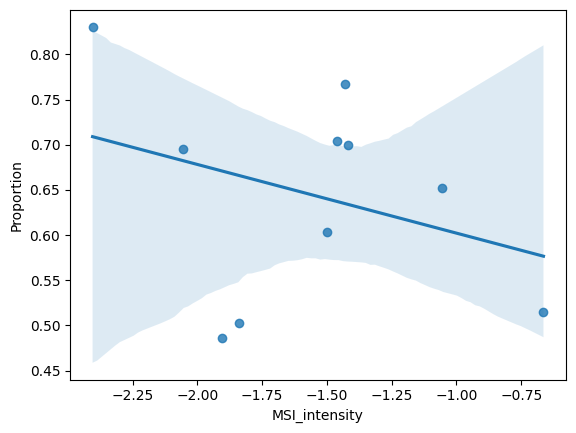

In [13]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
AuthorCellTypeLvl1_ProportionByPatient_oi = AuthorCellTypeLvl1_ProportionByPatient[(AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1']=='B') & 
                                                                                   ~(AuthorCellTypeLvl1_ProportionByPatient['PatientID'].isin(['P18', 'P21', 'P23']))]
AuthorCellTypeLvl1_ProportionByPatient_oi = AuthorCellTypeLvl1_ProportionByPatient[(AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1']=='T') ]
sns.regplot(data=AuthorCellTypeLvl1_ProportionByPatient_oi, x='MSI_intensity', y='Proportion',
            # order=chen_patient_order_by_MSI_intensity,
            )

stats.pearsonr( x=AuthorCellTypeLvl1_ProportionByPatient_oi['MSI_intensity'], y=AuthorCellTypeLvl1_ProportionByPatient_oi['Proportion'] )

### level 2

In [14]:
AuthorCellTypeLvl2_ProportionByPatient = list()

for PatientID, edf in adata_chen_tumorSamples[(adata_chen_tumorSamples.obs['Author_CellType_lvl_1']!='Epi')].obs.groupby('PatientID', observed=True,):
    for Author_CellType_lvl_2, edf2 in edf.groupby('Author_CellType_lvl_2', observed=True):
        AuthorCellTypeLvl2_ProportionByPatient.append( [PatientID, Author_CellType_lvl_2, edf2.iloc[0].Author_CellType_lvl_1, len(edf2), len(edf2)/len(edf), edf.iloc[0].Response] )
        
AuthorCellTypeLvl2_ProportionByPatient = pd.DataFrame(AuthorCellTypeLvl2_ProportionByPatient, columns=['PatientID', 'Author_CellType_lvl_2', 'Author_CellType_lvl_1', 'Count', 'Proportion', 'Response'])

AuthorCellTypeLvl2_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in AuthorCellTypeLvl2_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl2_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in AuthorCellTypeLvl2_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl2_ProportionByPatient['PerTumorCell'] = [ tup.Count/tup.TumorCellCount for tup in AuthorCellTypeLvl2_ProportionByPatient.itertuples() ]

In [16]:
dict_CT_to_Cor = dict()
for Author_CellType_lvl_2, edf in AuthorCellTypeLvl2_ProportionByPatient.groupby('Author_CellType_lvl_2', observed=True):
    try:
        dict_CT_to_Cor[Author_CellType_lvl_2] = (stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[0], stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[1])
    except ValueError:
        dict_CT_to_Cor[Author_CellType_lvl_2] = ( None, None )
        
AuthorCellTypeLvl2_ProportionByPatient['r'] = [ dict_CT_to_Cor[Author_CellType_lvl_2][0] for Author_CellType_lvl_2 in AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_2'] ]
AuthorCellTypeLvl2_ProportionByPatient['p'] = [ dict_CT_to_Cor[Author_CellType_lvl_2][1] for Author_CellType_lvl_2 in AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_2'] ]

<Axes: xlabel='MSI_intensity', ylabel='Proportion'>

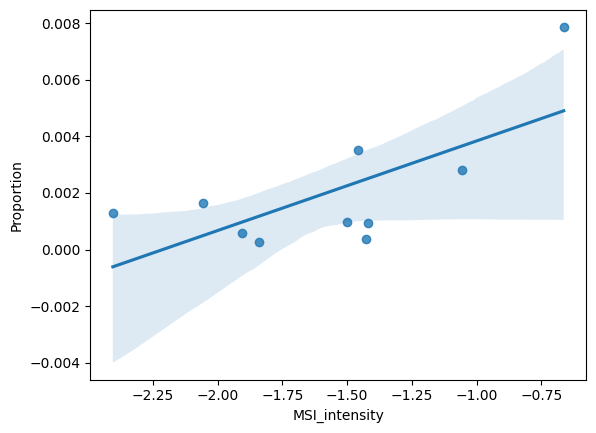

In [20]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
AuthorCellTypeLvl2_ProportionByPatient_oi = AuthorCellTypeLvl2_ProportionByPatient[(AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_1']=='B') & 
                                                                                   ~(AuthorCellTypeLvl2_ProportionByPatient['PatientID'].isin(['P18', 'P21', 'P23']))]
AuthorCellTypeLvl2_ProportionByPatient_oi = AuthorCellTypeLvl2_ProportionByPatient[(AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_2']=='c17_CD8_Tcm_GPR183') ]
sns.regplot(data=AuthorCellTypeLvl2_ProportionByPatient_oi, x='MSI_intensity', y='Proportion',
            # order=chen_patient_order_by_MSI_intensity,
            )

### level 1 + TissueEnrichmentAnalysis

In [28]:
AuthorCellTypeLvl1_ProportionByPatient = list()

# Change from Author_CellType_lvl_1/Manual_CellType_lvl_1
# for PatientID, edf in adata_chen[adata_chen.obs['Author_CellType_lvl_1']!='Epi'].obs.groupby('PatientID', observed=True,):
for PatientID, edf in adata_chen[adata_chen.obs['Manual_CellType_lvl_1']!='Epithelial'].obs.groupby('PatientID', observed=True,):
    for BiopsySite, edf2 in edf.groupby('BiopsySite', observed=True):
        for Author_CellType_lvl_1, edf3 in edf2.groupby('Manual_CellType_lvl_1', observed=True):
            AuthorCellTypeLvl1_ProportionByPatient.append( [PatientID, 
                                                            BiopsySite, 
                                                            Author_CellType_lvl_1,
                                                            len(edf3), 
                                                            len(edf2), 
                                                            len(edf3)/len(edf2), 
                                                            edf.iloc[0].Response, ] )
        
AuthorCellTypeLvl1_ProportionByPatient = pd.DataFrame(AuthorCellTypeLvl1_ProportionByPatient, columns=['PatientID', 
                                                                                                       'BiopsySite',
                                                                                                       'Author_CellType_lvl_1',
                                                                                                       'CountWithinSample', 
                                                                                                       'TotalCount',
                                                                                                       'Proportion', 'Response'])

AuthorCellTypeLvl1_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl1_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]


dict_CT_to_Cor = dict()
for Author_CellType_lvl_1, edf in AuthorCellTypeLvl1_ProportionByPatient[(AuthorCellTypeLvl1_ProportionByPatient['BiopsySite']=='Tumor')].groupby('Author_CellType_lvl_1', observed=True):
    try:
        dict_CT_to_Cor[Author_CellType_lvl_1] = (stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[0], stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[1])
    except ValueError:
        dict_CT_to_Cor[Author_CellType_lvl_1] = ( None, None )
for Author_CellType_lvl_1 in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1']:
    try: dict_CT_to_Cor[Author_CellType_lvl_1]
    except KeyError: dict_CT_to_Cor[Author_CellType_lvl_1] = ( None, None )
        
AuthorCellTypeLvl1_ProportionByPatient['r'] = [ dict_CT_to_Cor[Author_CellType_lvl_1][0] for Author_CellType_lvl_1 in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1'] ]
AuthorCellTypeLvl1_ProportionByPatient['p'] = [ dict_CT_to_Cor[Author_CellType_lvl_1][1] for Author_CellType_lvl_1 in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1'] ]

In [29]:
dict_CellType_to_Enrichment = dict()
T_totalCellCount = sum(AuthorCellTypeLvl1_ProportionByPatient[AuthorCellTypeLvl1_ProportionByPatient['BiopsySite']=='Tumor']['CountWithinSample'])
N_totalCellCount = sum(AuthorCellTypeLvl1_ProportionByPatient[AuthorCellTypeLvl1_ProportionByPatient['BiopsySite']=='Normal']['CountWithinSample'])
print(T_totalCellCount, N_totalCellCount)
dict_BiopsySite_to_TotalCount = { 'Tumor' : T_totalCellCount,'Normal' : N_totalCellCount }

for CellType, edf in AuthorCellTypeLvl1_ProportionByPatient.groupby('Author_CellType_lvl_1'):
    # dict_BiopsySite_to_Proportion = { tup.BiopsySite : tup.Proportion for tup in edf.itertuples() }
    try:
        dict_BiopsySite_to_Proportion = { BiopsySite : sum(edf2['CountWithinSample'])/dict_BiopsySite_to_TotalCount[BiopsySite] for BiopsySite, edf2 in edf.groupby('BiopsySite') }
        dict_CellType_to_Enrichment[CellType] = calcSampleEnrichment(dict_BiopsySite_to_Proportion['Tumor'], dict_BiopsySite_to_Proportion['Normal'])

    except: 
        print(CellType, sum(edf['CountWithinSample']))
        dict_CellType_to_Enrichment[CellType] = None
        continue 

AuthorCellTypeLvl1_ProportionByPatient['TissueEnrichment'] = [ dict_CellType_to_Enrichment[CellType] for CellType in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1'] ]

26849 36701


In [30]:
AuthorCellTypeLvl1_ProportionByPatient['r_neg'] = [ -r for r in AuthorCellTypeLvl1_ProportionByPatient['r'] ]

In [33]:
s_chen = {'B',
 'Dendritic',
 'Endothelial',
 'Epithelial',
 'Fibroblast',
 'Glial',
 'Mast',
 'Monocyte/Macrophage',
 'N/A',
 'NK',
 'Pericyte',
 'Plasma',
 'SMC',
 'T'}

s_joanito = {'B',
 'Dendritic',
 'Epithelial',
 'Fibroblast',
 'Glial',
 'Mast',
 'Monocyte/Macrophage',
 'N/A',
 'NK',
 'Pericyte',
 'Plasma',
 'SMC',
 'Stromal',
 'T'}

s_union = s_chen.union(s_joanito)
len(s_union)

15

Mast
Plasma
Dendritic
Fibroblast
Epithelial
N/A
Monocyte/Macrophage
Glial
Endothelial
T
B
Pericyte
NK
Stromal
SMC


In [51]:
palette_e = sns.color_palette('husl', n_colors=9) + sns.color_palette('Set2', n_colors=6)
dict_ct_to_color = { ct : palette_e[idx] for idx, ct in enumerate(s_union) }
dict_ct_to_color

{'Mast': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'Plasma': (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 'Dendritic': (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 'Fibroblast': (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 'Epithelial': (0.20582072623426667, 0.6842209016721068, 0.5675558225732941),
 'N/A': (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 'Monocyte/Macrophage': (0.23299120924703914,
  0.639586552066035,
  0.9260706093977744),
 'Glial': (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 'Endothelial': (0.9614880299080136, 0.3909885385134758, 0.8298287106954371),
 'T': (0.4, 0.7607843137254902, 0.6470588235294118),
 'B': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'Pericyte': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'NK': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'Stromal': (0.6509803921568628, 0.847058823529411

In [55]:
len(set(AuthorCellTypeLvl1_ProportionByPatient['PatientID']))

10

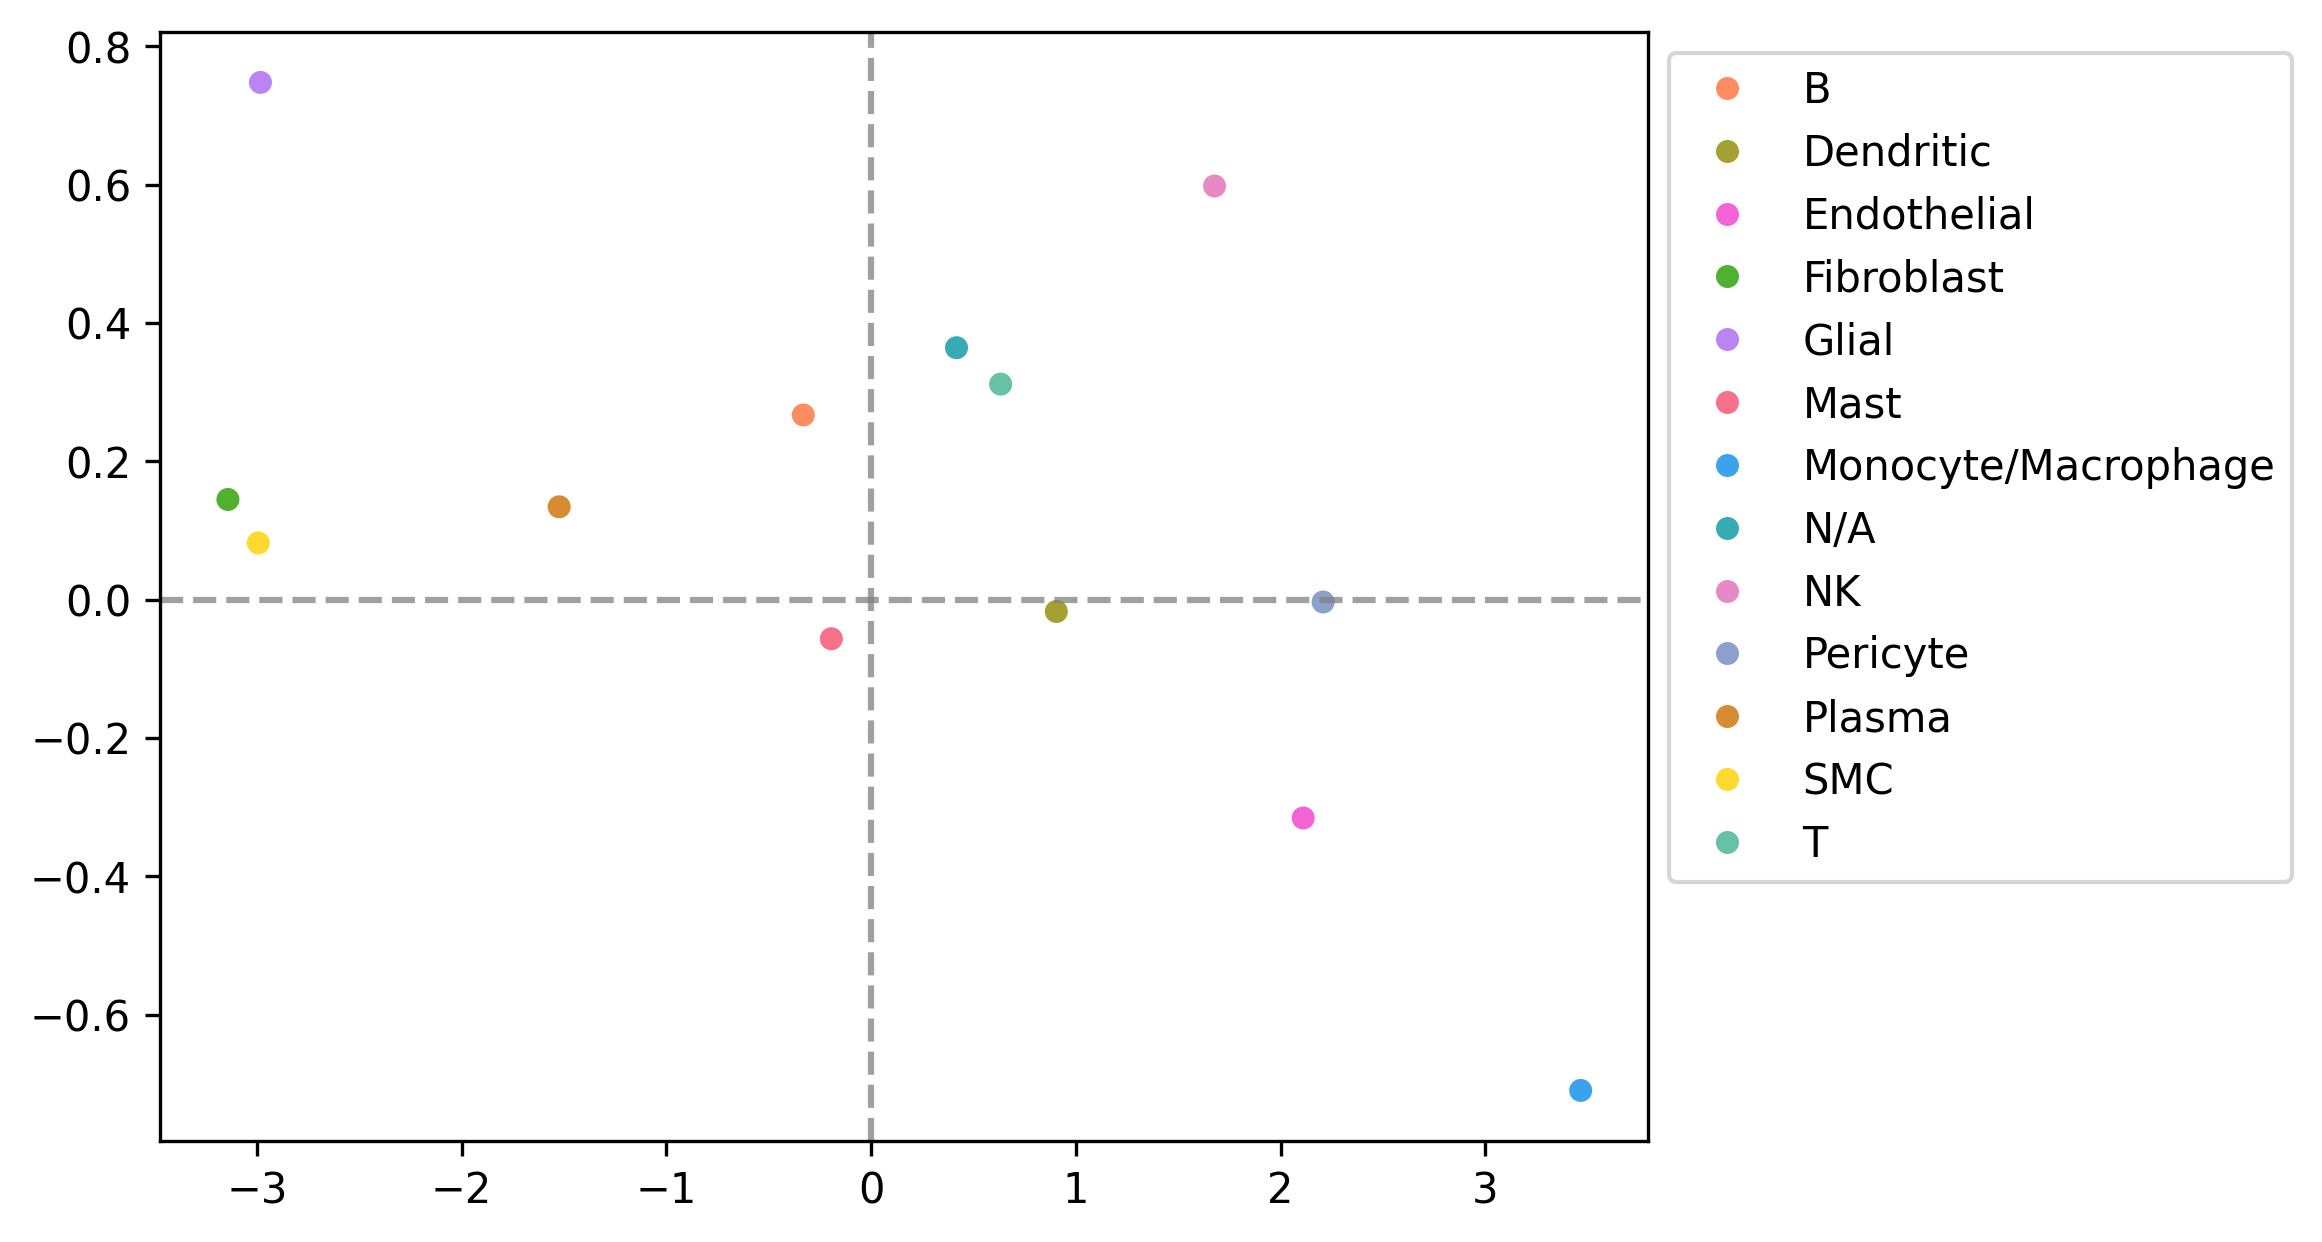

In [52]:
plt.figure(dpi=300)
ax = sns.scatterplot(data=AuthorCellTypeLvl1_ProportionByPatient, x='TissueEnrichment', y='r_neg', hue='Author_CellType_lvl_1', palette=dict_ct_to_color)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='')
plt.axvline(0, color='gray', ls='--', alpha=0.75)
plt.axhline(0, color='gray', ls='--', alpha=0.75)
ax.set_xlabel('');
ax.set_ylabel('');

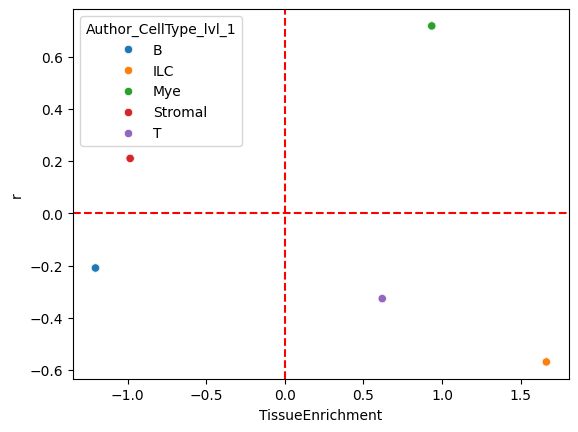

In [13]:
sns.scatterplot(data=AuthorCellTypeLvl1_ProportionByPatient, x='TissueEnrichment', y='r', hue='Author_CellType_lvl_1', legend=True)
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')

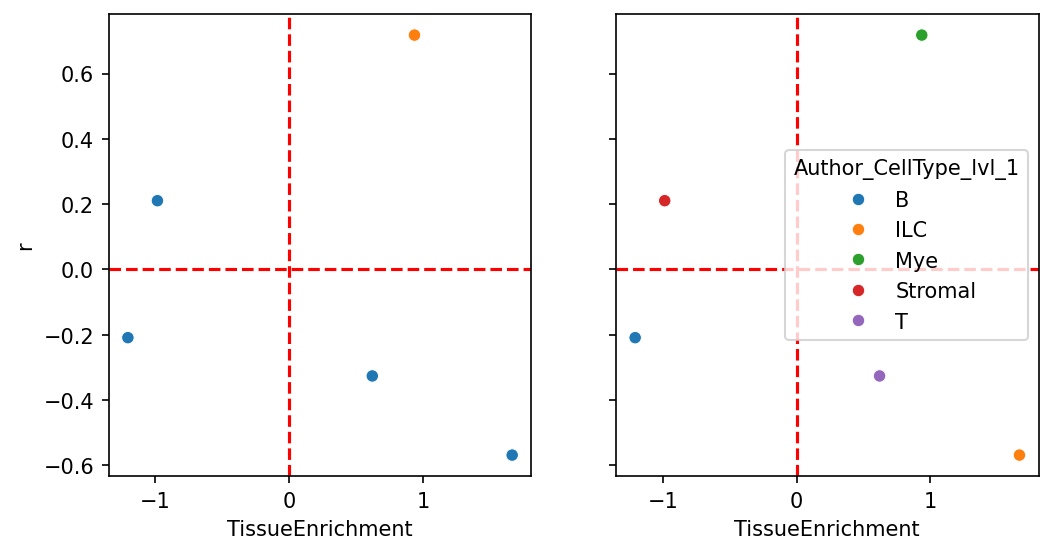

In [112]:
AuthorCellTypeLvl1_ProportionByPatient['significant'] = [ bool(p<=0.05) for p in AuthorCellTypeLvl1_ProportionByPatient['p'] ]
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True, sharex=True)
sns.scatterplot(data=AuthorCellTypeLvl1_ProportionByPatient, x='TissueEnrichment', y='r', hue='significant', legend=None, ax=axes[0])
axes[0].axhline(0, color='r', ls='--')
axes[0].axvline(0, color='r', ls='--')

sns.scatterplot(data=AuthorCellTypeLvl1_ProportionByPatient, x='TissueEnrichment', y='r', hue='Author_CellType_lvl_1', legend=True, ax=axes[1])
axes[1].axhline(0, color='r', ls='--')
axes[1].axvline(0, color='r', ls='--')

In [110]:
for Author_CellType_lvl_1, edf in AuthorCellTypeLvl1_ProportionByPatient[AuthorCellTypeLvl1_ProportionByPatient['significant']==True].groupby('Author_CellType_lvl_1'):
    print(f'{Author_CellType_lvl_1}\t{round(100*np.mean(edf['Proportion']), 2)}')

Mye	5.42


### level 2 + TissueEnrichmentAnalysis

In [113]:
AuthorCellTypeLvl2_ProportionByPatient = list()

for PatientID, edf in adata_chen[adata_chen.obs['Author_CellType_lvl_1']!='Epi'].obs.groupby('PatientID', observed=True,):
    for BiopsySite, edf2 in edf.groupby('BiopsySite', observed=True):
        for Author_CellType_lvl_2, edf3 in edf2.groupby('Author_CellType_lvl_2', observed=True):
            AuthorCellTypeLvl2_ProportionByPatient.append( [PatientID, 
                                                            BiopsySite, 
                                                            Author_CellType_lvl_2,
                                                            edf3.iloc[0].Author_CellType_lvl_1, 
                                                            len(edf3), 
                                                            len(edf2), 
                                                            len(edf3)/len(edf2), 
                                                            edf.iloc[0].Response, ] )
        
AuthorCellTypeLvl2_ProportionByPatient = pd.DataFrame(AuthorCellTypeLvl2_ProportionByPatient, columns=['PatientID', 
                                                                                                       'BiopsySite',
                                                                                                       'Author_CellType_lvl_2', 
                                                                                                       'Author_CellType_lvl_1',
                                                                                                       'CountWithinSample', 
                                                                                                       'TotalCount',
                                                                                                       'Proportion', 'Response'])

AuthorCellTypeLvl2_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in AuthorCellTypeLvl2_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl2_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in AuthorCellTypeLvl2_ProportionByPatient['PatientID'] ]


dict_CT_to_Cor = dict()
for Author_CellType_lvl_2, edf in AuthorCellTypeLvl2_ProportionByPatient[(AuthorCellTypeLvl2_ProportionByPatient['BiopsySite']=='Tumor')].groupby('Author_CellType_lvl_2', observed=True):
    try:
        dict_CT_to_Cor[Author_CellType_lvl_2] = (stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[0], stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[1])
    except ValueError:
        dict_CT_to_Cor[Author_CellType_lvl_2] = ( None, None )
for Author_CellType_lvl_2 in AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_2']:
    try: dict_CT_to_Cor[Author_CellType_lvl_2]
    except KeyError: dict_CT_to_Cor[Author_CellType_lvl_2] = ( None, None )
        
AuthorCellTypeLvl2_ProportionByPatient['r'] = [ dict_CT_to_Cor[Author_CellType_lvl_2][0] for Author_CellType_lvl_2 in AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_2'] ]
AuthorCellTypeLvl2_ProportionByPatient['p'] = [ dict_CT_to_Cor[Author_CellType_lvl_2][1] for Author_CellType_lvl_2 in AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_2'] ]

In [114]:
AuthorCellTypeLvl2_ProportionByPatient

,PatientID,BiopsySite,Author_CellType_lvl_2,Author_CellType_lvl_1,CountWithinSample,TotalCount,Proportion,Response,MSI_intensity,TumorCellCount,r,p
0,P04,Normal,c01_CD4_Tn_CCR7,T,24,7945,0.003021,CR,-2.404214,1186,-0.025878,0.961192
1,P04,Normal,c03_CD4_Tn_NR4A2,T,886,7945,0.111517,CR,-2.404214,1186,0.241824,0.530740
2,P04,Normal,c04_CD4_Tcm_ANXA1,T,8,7945,0.001007,CR,-2.404214,1186,0.219154,0.571028
3,P04,Normal,c05_CD4_Tcm_GPR183,T,868,7945,0.109251,CR,-2.404214,1186,0.102447,0.778235
4,P04,Normal,c06_CD4_Trm_HSPA1A,T,252,7945,0.031718,CR,-2.404214,1186,-0.185142,0.608601
...,...,...,...,...,...,...,...,...,...,...,...,...
1087,P26,Tumor,c75_Fibro_CCL19,Stromal,1,3244,0.000308,CR,-1.418801,980,-0.209266,0.790734
1088,P26,Tumor,c77_Fibro_ACTA2,Stromal,1,3244,0.000308,CR,-1.418801,980,0.577572,0.229978
1089,P26,Tumor,c79_Fibro_FAP,Stromal,2,3244,0.000617,CR,-1.418801,980,0.100404,0.797168
1090,P26,Tumor,c81_Pericyte_RGS5,Stromal,5,3244,0.001541,CR,-1.418801,980,-0.147515,0.684243


In [115]:
dict_CellType_to_Enrichment = dict()
T_totalCellCount = sum(AuthorCellTypeLvl2_ProportionByPatient[AuthorCellTypeLvl2_ProportionByPatient['BiopsySite']=='Tumor']['CountWithinSample'])
N_totalCellCount = sum(AuthorCellTypeLvl2_ProportionByPatient[AuthorCellTypeLvl2_ProportionByPatient['BiopsySite']=='Normal']['CountWithinSample'])
print(T_totalCellCount, N_totalCellCount)
dict_BiopsySite_to_TotalCount = { 'Tumor' : T_totalCellCount,'Normal' : N_totalCellCount }

for CellType, edf in AuthorCellTypeLvl2_ProportionByPatient.groupby('Author_CellType_lvl_2'):
    # dict_BiopsySite_to_Proportion = { tup.BiopsySite : tup.Proportion for tup in edf.itertuples() }
    try:
        dict_BiopsySite_to_Proportion = { BiopsySite : sum(edf2['CountWithinSample'])/dict_BiopsySite_to_TotalCount[BiopsySite] for BiopsySite, edf2 in edf.groupby('BiopsySite') }
        dict_CellType_to_Enrichment[CellType] = calcSampleEnrichment(dict_BiopsySite_to_Proportion['Tumor'], dict_BiopsySite_to_Proportion['Normal'])

    except: 
        print(CellType, sum(edf['CountWithinSample']))
        dict_CellType_to_Enrichment[CellType] = None
        continue 

AuthorCellTypeLvl2_ProportionByPatient['TissueEnrichment'] = [ dict_CellType_to_Enrichment[CellType] for CellType in AuthorCellTypeLvl2_ProportionByPatient['Author_CellType_lvl_2'] ]

26852 36703
c36_ILC_SYNE2 2
c49_Mono_CD14 14
c51_Mono_NFKBIZ 3
c53_Neu_CXCR2 22
c54_pDC_LILRA4 2
c56_tDC_SIGLEC6 1
c64_Mph_SPP1 46
c74_Fibro_C7 161
c76_Fibro_PI16 3
c79_Fibro_FAP 81
c80_Fibro_MKI67 11


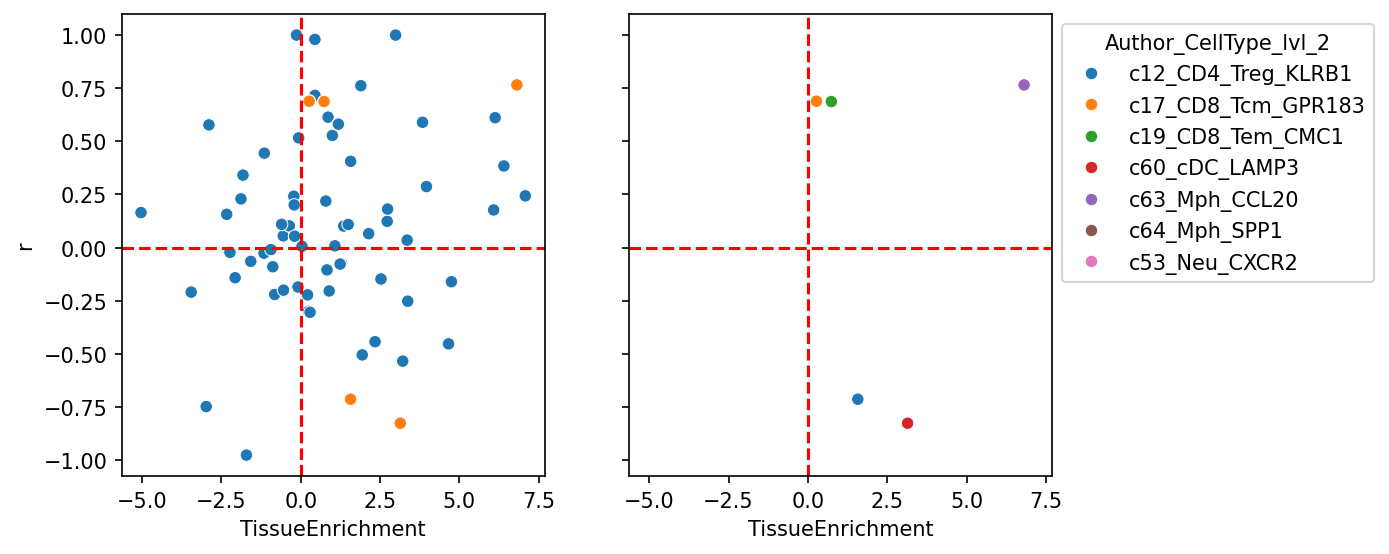

In [127]:
AuthorCellTypeLvl2_ProportionByPatient['significant'] = [ bool(p<=0.05) for p in AuthorCellTypeLvl2_ProportionByPatient['p'] ]
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True, sharex=True)
sns.scatterplot(data=AuthorCellTypeLvl2_ProportionByPatient, x='TissueEnrichment', y='r', hue='significant', legend=None, ax=axes[0])
axes[0].axhline(0, color='r', ls='--')
axes[0].axvline(0, color='r', ls='--')

f = sns.scatterplot(data=AuthorCellTypeLvl2_ProportionByPatient[AuthorCellTypeLvl2_ProportionByPatient['significant']==True], x='TissueEnrichment', y='r', hue='Author_CellType_lvl_2', legend=True, ax=axes[1])
sns.move_legend(f, "upper left", bbox_to_anchor=(1, 1))
axes[1].axhline(0, color='r', ls='--')
axes[1].axvline(0, color='r', ls='--')

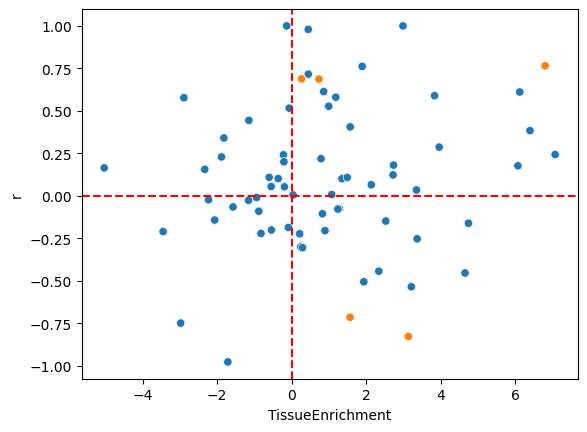

In [132]:
sns.scatterplot(data=AuthorCellTypeLvl2_ProportionByPatient, x='TissueEnrichment', y='r', hue='significant', legend=None)
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')

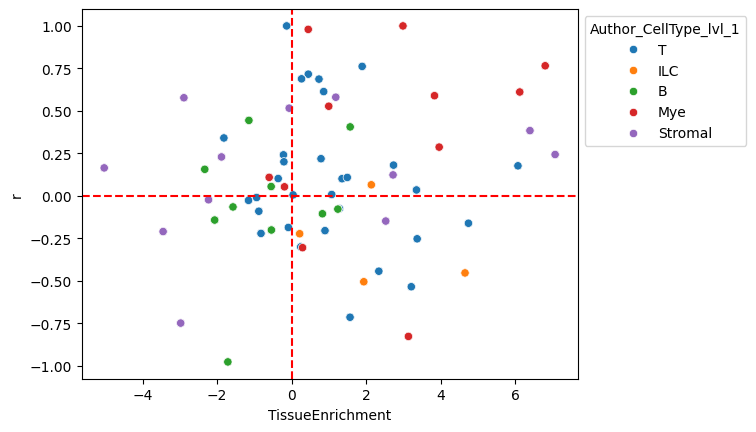

In [137]:
f = sns.scatterplot(data=AuthorCellTypeLvl2_ProportionByPatient, x='TissueEnrichment', y='r', hue='Author_CellType_lvl_1', )
sns.move_legend(f, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')

In [273]:

def makeColumns( vcf ):
    col_DP = list()
    col_VDB = list()
    col_SGB = list()
    col_RPBZ = list()
    col_AC = list()

    col_ReferenceAllele = list()
    col_AlternateAllele = list()

    for tup in vcf.itertuples():
        info = tup.INFO.split(";")
        for elem in info:
            if 'DP=' in elem:
                col_DP.append( int(elem.split('=')[1]) )
            elif 'VDB=' in elem:
                col_VDB.append( float(elem.split('=')[1]) )
            elif 'SGB=' in elem:
                col_SGB.append( float(elem.split('=')[1]) )
            elif 'AC=' in elem:
                try:
                    col_AC.append( int(elem.split('=')[1]) )
                except ValueError:
                    col_AC.append( 'Multiple' )
            elif 'DP4=' in elem:
                col_ReferenceAllele.append( int(elem.split('=')[1].split(',')[0]) + int(elem.split('=')[1].split(',')[1]) )
                col_AlternateAllele.append( int(elem.split('=')[1].split(',')[2]) + int(elem.split('=')[1].split(',')[3]) )
    
    vcf['DP'] = col_DP
    vcf['VDB'] = col_VDB
    vcf['SGB'] = col_SGB
    vcf['AC'] = col_AC
    vcf['ReferenceAlleleCount'] = col_ReferenceAllele
    vcf['AlternateAlleleCount'] = col_AlternateAllele
    
leiden0_vcf = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/sub1_leiden0.output.vcf', sep='\t', skiprows=221)
leiden1_vcf = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/sub1_leiden1.output.vcf', sep='\t', skiprows=221)
normal1_vcf = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/normal.output.vcf', sep='\t', skiprows=221)
normal2_vcf = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/normal2.output.vcf', sep='\t', skiprows=221)

# leiden0_vcf['locus'] = [ f'{list(tup)[0]}-{tup.POS}-{tup.REF}-{tup.ALT}' for tup in leiden0_vcf.itertuples() ]
# leiden1_vcf['locus'] = [ f'{list(tup)[0]}-{tup.POS}-{tup.REF}-{tup.ALT}' for tup in leiden1_vcf.itertuples() ]
leiden0_vcf['locus'] = [ f'{list(tup)[1]}-{tup.POS}' for tup in leiden0_vcf.itertuples() ]
leiden1_vcf['locus'] = [ f'{list(tup)[1]}-{tup.POS}' for tup in leiden1_vcf.itertuples() ]
normal1_vcf['locus'] = [ f'{list(tup)[1]}-{tup.POS}' for tup in normal1_vcf.itertuples() ]
normal2_vcf['locus'] = [ f'{list(tup)[1]}-{tup.POS}' for tup in normal2_vcf.itertuples() ]

makeColumns(leiden0_vcf) 
makeColumns(leiden1_vcf)
makeColumns(normal1_vcf) 
makeColumns(normal2_vcf)

coverage_threshold = 100
QUAL_threshold = 20

leiden0_vcf = leiden0_vcf[(leiden0_vcf['ReferenceAlleleCount']>=coverage_threshold) & 
                            (leiden0_vcf['AlternateAlleleCount']>=coverage_threshold) & 
                            (leiden0_vcf['VDB']<=0.2) & 
                            (leiden0_vcf['QUAL']>=QUAL_threshold) &
                            (leiden0_vcf['REF'].isin(['G', 'A', 'T', 'C'])) & 
                            (leiden0_vcf['ALT'].isin(['G', 'A', 'T', 'C']))].copy()

leiden1_vcf = leiden1_vcf[(leiden1_vcf['ReferenceAlleleCount']>=coverage_threshold) & 
                            (leiden1_vcf['AlternateAlleleCount']>=coverage_threshold) & 
                            (leiden1_vcf['VDB']<=0.2) & 
                            (leiden1_vcf['QUAL']>=QUAL_threshold) &
                            (leiden1_vcf['REF'].isin(['G', 'A', 'T', 'C'])) & 
                            (leiden1_vcf['ALT'].isin(['G', 'A', 'T', 'C']))].copy()

normal1_vcf = normal1_vcf[(normal1_vcf['ReferenceAlleleCount']>=coverage_threshold) & 
                            (normal1_vcf['AlternateAlleleCount']>=coverage_threshold) & 
                            (normal1_vcf['VDB']<=0.2) & 
                            (normal1_vcf['QUAL']>=QUAL_threshold) &
                            (normal1_vcf['REF'].isin(['G', 'A', 'T', 'C'])) & 
                            (normal1_vcf['ALT'].isin(['G', 'A', 'T', 'C']))].copy()

normal2_vcf = normal2_vcf[(normal2_vcf['ReferenceAlleleCount']>=coverage_threshold) & 
                            (normal2_vcf['AlternateAlleleCount']>=coverage_threshold) & 
                            (normal2_vcf['VDB']<=0.2) & 
                            (normal2_vcf['QUAL']>=QUAL_threshold) &
                            (normal2_vcf['REF'].isin(['G', 'A', 'T', 'C'])) & 
                            (normal2_vcf['ALT'].isin(['G', 'A', 'T', 'C']))].copy()

print(leiden0_vcf.shape)
print(leiden1_vcf.shape)
print(normal1_vcf.shape)
print(normal2_vcf.shape)

(112, 17)
(19, 17)
(7, 17)
(39, 17)


In [278]:
leiden0_vcf

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,EXT048,locus,DP,VDB,SGB,AC,ReferenceAlleleCount,AlternateAlleleCount
512,chr1,8861276,.,C,T,26.3973,.,DP=244;VDB=6.93078e-07;SGB=-0.693147;RPBZ=0.43...,GT:PL,"0/1:59,0,61",chr1-8861276,244,6.930780e-07,-0.693147,1,129,115
1148,chr1,19658302,.,C,A,21.4335,.,DP=229;VDB=0.0171279;SGB=-0.693147;RPBZ=-0.572...,GT:PL,"0/1:54,0,57",chr1-19658302,229,1.712790e-02,-0.693147,1,117,112
2914,chr1,47368537,.,G,T,26.4097,.,DP=244;VDB=8.98571e-08;SGB=-0.693147;RPBZ=-0.5...,GT:PL,"0/1:59,0,55",chr1-47368537,244,8.985710e-08,-0.693147,1,117,127
5775,chr1,156055305,.,C,T,26.4134,.,DP=236;VDB=0.0308353;SGB=-0.693147;RPBZ=0.7737...,GT:PL,"0/1:59,0,57",chr1-156055305,236,3.083530e-02,-0.693147,1,117,119
5795,chr1,156232382,.,A,G,24.4163,.,DP=220;VDB=2.10475e-06;SGB=-0.693147;RPBZ=-0.1...,GT:PL,"0/1:57,0,52",chr1-156232382,220,2.104750e-06,-0.693147,1,105,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90310,chr8,102863955,.,G,A,30.3975,.,DP=232;VDB=0.000818992;SGB=-0.693147;RPBZ=0.79...,GT:PL,"0/1:63,0,52",chr8-102863955,232,8.189920e-04,-0.693147,1,111,121
91117,chr8,143577876,.,G,A,23.4237,.,DP=232;VDB=0.00602628;SGB=-0.693147;RPBZ=0.215...,GT:PL,"0/1:56,0,56",chr8-143577876,232,6.026280e-03,-0.693147,1,116,116
91121,chr8,143580183,.,G,A,21.4163,.,DP=221;VDB=6.90911e-05;SGB=-0.693147;RPBZ=-1.2...,GT:PL,"0/1:54,0,62",chr8-143580183,221,6.909110e-05,-0.693147,1,118,103
91148,chr8,143614871,.,A,G,24.4194,.,DP=233;VDB=0.012047;SGB=-0.693147;RPBZ=-0.4433...,GT:PL,"0/1:57,0,55",chr8-143614871,233,1.204700e-02,-0.693147,1,116,117


In [123]:
for Author_CellType_lvl_2, edf in AuthorCellTypeLvl2_ProportionByPatient[AuthorCellTypeLvl2_ProportionByPatient['significant']==True].groupby('Author_CellType_lvl_2'):
    print(f'{Author_CellType_lvl_2}\t{round(100*np.mean(edf['Proportion']), 2)}')

c12_CD4_Treg_KLRB1	2.09
c17_CD8_Tcm_GPR183	0.17
c19_CD8_Tem_CMC1	0.22
c53_Neu_CXCR2	0.19
c60_cDC_LAMP3	0.25
c63_Mph_CCL20	1.87
c64_Mph_SPP1	0.56


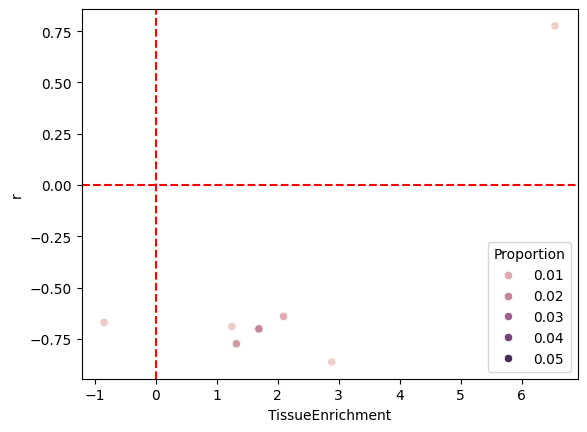

In [93]:
sns.scatterplot(data=AuthorCellTypeLvl2_ProportionByPatient[AuthorCellTypeLvl2_ProportionByPatient['significant']==True], x='TissueEnrichment', y='r', hue='Author_CellType_lvl_2', legend=True,)
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')


In [89]:
AuthorCellTypeLvl2_ProportionByPatient[(AuthorCellTypeLvl2_ProportionByPatient['significant']==True) & 
                                       (AuthorCellTypeLvl2_ProportionByPatient['r']<=0) & 
                                       (AuthorCellTypeLvl2_ProportionByPatient['TissueEnrichment']>=1)].head(20)[['Author_CellType_lvl_2', 'CountWithinSample', 'Proportion', 'TissueEnrichment', 'r', 'p']].sort_values('TissueEnrichment')

,Author_CellType_lvl_2,CountWithinSample,Proportion,TissueEnrichment,r,p
25,c30_gdT_TRDV2,14,0.001589,1.245036,-0.689955,0.039703
90,c30_gdT_TRDV2,16,0.002709,1.245036,-0.689955,0.039703
160,c30_gdT_TRDV2,2,0.000308,1.245036,-0.689955,0.039703
230,c30_gdT_TRDV2,8,0.001007,1.245036,-0.689955,0.039703
144,c12_CD4_Treg_KLRB1,45,0.006935,1.319334,-0.774075,0.008590
9,c12_CD4_Treg_KLRB1,178,0.020209,1.319334,-0.774075,0.008590
213,c12_CD4_Treg_KLRB1,167,0.021027,1.319334,-0.774075,0.008590
74,c12_CD4_Treg_KLRB1,314,0.053157,1.319334,-0.774075,0.008590
93,c34_ILC_NR4A2,157,0.026579,1.688546,-0.701383,0.023807
233,c34_ILC_NR4A2,86,0.010829,1.688546,-0.701383,0.023807


In [70]:
set(AuthorCellTypeLvl2_ProportionByPatient[AuthorCellTypeLvl2_ProportionByPatient['p']<=0.05]['Author_CellType_lvl_2'])

{'c07_CD4_Th17_CTSH',
 'c12_CD4_Treg_KLRB1',
 'c30_gdT_TRDV2',
 'c34_ILC_NR4A2',
 'c59_cDC_IL1B',
 'c60_cDC_LAMP3',
 'c63_Mph_CCL20',
 'c64_Mph_SPP1'}